# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [15]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 3

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [16]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [17]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [18]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.816
[2] loss: 0.992
[3] loss: 0.670
[4] loss: 0.428
[5] loss: 0.317
[6] loss: 0.201
[7] loss: 0.132
[8] loss: 0.093
[9] loss: 0.063
[10] loss: 0.044
[11] loss: 0.036
[12] loss: 0.027
[13] loss: 0.019
[14] loss: 0.021
[15] loss: 0.016
[16] loss: 0.009
[17] loss: 0.011
[18] loss: 0.014
[19] loss: 0.011
[20] loss: 0.009
[21] loss: 0.004
[22] loss: 0.009
[23] loss: 0.009
[24] loss: 0.005
[25] loss: 0.006


In [19]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 3])

In [20]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

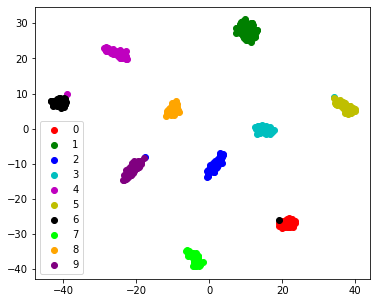

In [21]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

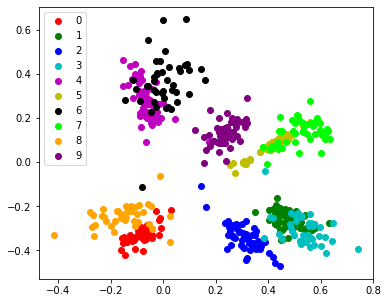

In [31]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [23]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [24]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [25]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[-0.0690,  0.4834,  0.3276,  0.5517, -0.0672,  0.4080,  0.0293,  0.5260,
         -0.1285,  0.2468],
        [-0.1063, -0.0953,  0.6253,  0.3147,  0.2705, -0.1752, -0.1374,  0.2898,
          0.2918,  0.5158],
        [-0.3185, -0.2623, -0.3406, -0.3056,  0.2944,  0.0752,  0.3474,  0.1299,
         -0.2362,  0.1512]])

In [26]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [32]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_2.cfg')

['./config/sswae_dev2_2.cfg']

In [33]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_{y_dim}.pt'))
mm.train()

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 3
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [001/100]  loss: 2.361395e-01  D: 6.915082e-01  D2: 1.792473e-02  D3: 3.274976e-03
test loss: 1.733753e-01  D: 6.753257e-01  D2: 2.056389e-03  D3: 7.009804e-03


[default |INFO|model.py:1280] [002/100]  loss: 1.645627e-01  D: 6.971816e-01  D2: -3.410303e-03  D3: 7.147643e-03
test loss: 1.552395e-01  D: 7.093701e-01  D2: -3.510160e-03  D3: 7.251621e-03


[default |INFO|model.py:1280] [003/100]  loss: 1.464787e-01  D: 6.931733e-01  D2: -4.039467e-03  D3: 4.176936e-03
test loss: 1.430795e-01  D: 6.739330e-01  D2: -3.792238e-03  D3: 7.317097e-03


[default |INFO|model.py:1280] [004/100]  loss: 1.312438e-01  D: 6.946392e-01  D2: -3.578073e-03  D3: 7.915422e-03
test loss: 1.761991e-01  D: 7.086170e-01  D2: -2.801867e-03  D3: 8.949805e-03


[default |INFO|model.py:1280] [005/100]  loss: 1.442759e-01  D: 7.041588e-01  D2: -3.445048e-03  D3: 1.384228e-02
test loss: 1.253909e-01  D: 6.909168e-01  D2: -2.651691e-03  D3: 1.189579e-02


[default |INFO|model.py:1280] [006/100]  loss: 1.098708e-01  D: 6.937794e-01  D2: -3.956385e-03  D3: 9.866392e-03
test loss: 1.007037e-01  D: 6.911933e-01  D2: -4.619417e-03  D3: 1.082898e-02


[default |INFO|model.py:1280] [007/100]  loss: 1.055319e-01  D: 6.944416e-01  D2: -3.443799e-03  D3: 1.452387e-02
test loss: 9.707629e-02  D: 6.663410e-01  D2: -4.328947e-03  D3: 1.600433e-02


[default |INFO|model.py:1280] [008/100]  loss: 9.538539e-02  D: 6.942073e-01  D2: -3.995493e-03  D3: 1.436357e-02
test loss: 9.138722e-02  D: 6.903610e-01  D2: -3.964996e-03  D3: 1.547813e-02


[default |INFO|model.py:1280] [009/100]  loss: 8.835686e-02  D: 6.936570e-01  D2: -3.846455e-03  D3: 1.417801e-02
test loss: 8.641026e-02  D: 6.891276e-01  D2: -4.415579e-03  D3: 1.491006e-02


[default |INFO|model.py:1280] [010/100]  loss: 8.574318e-02  D: 6.938200e-01  D2: -3.952276e-03  D3: 1.401588e-02
test loss: 8.535437e-02  D: 6.954769e-01  D2: -5.136366e-03  D3: 1.162807e-02


[default |INFO|model.py:1280] [011/100]  loss: 8.420339e-02  D: 6.948784e-01  D2: -4.256814e-03  D3: 1.376634e-02
test loss: 8.362524e-02  D: 6.966925e-01  D2: -4.414129e-03  D3: 1.323104e-02


[default |INFO|model.py:1280] [012/100]  loss: 8.158483e-02  D: 6.944284e-01  D2: -4.301133e-03  D3: 1.315431e-02
test loss: 8.106952e-02  D: 6.971866e-01  D2: -3.710384e-03  D3: 1.489130e-02


[default |INFO|model.py:1280] [013/100]  loss: 7.895974e-02  D: 6.933736e-01  D2: -4.416817e-03  D3: 1.322459e-02
test loss: 7.772215e-02  D: 6.876769e-01  D2: -4.373188e-03  D3: 1.311724e-02


[default |INFO|model.py:1280] [014/100]  loss: 7.763124e-02  D: 6.944503e-01  D2: -4.664764e-03  D3: 1.306026e-02
test loss: 7.959559e-02  D: 6.848495e-01  D2: -5.128975e-03  D3: 1.019432e-02


[default |INFO|model.py:1280] [015/100]  loss: 7.654195e-02  D: 6.937592e-01  D2: -4.600129e-03  D3: 1.298721e-02
test loss: 7.518607e-02  D: 6.901445e-01  D2: -4.432354e-03  D3: 1.235474e-02


[default |INFO|model.py:1280] [016/100]  loss: 7.547101e-02  D: 6.938774e-01  D2: -4.907080e-03  D3: 1.299602e-02
test loss: 7.650142e-02  D: 6.869078e-01  D2: -4.957209e-03  D3: 1.385114e-02


[default |INFO|model.py:1280] [017/100]  loss: 7.455829e-02  D: 6.933892e-01  D2: -4.874282e-03  D3: 1.275715e-02
test loss: 7.604740e-02  D: 6.964900e-01  D2: -4.542770e-03  D3: 1.337258e-02


[default |INFO|model.py:1280] [018/100]  loss: 7.449960e-02  D: 6.932750e-01  D2: -4.937577e-03  D3: 1.286519e-02
test loss: 7.383656e-02  D: 6.937707e-01  D2: -5.511847e-03  D3: 1.329902e-02


[default |INFO|model.py:1280] [019/100]  loss: 7.351071e-02  D: 6.939122e-01  D2: -5.220011e-03  D3: 1.276020e-02
test loss: 7.321268e-02  D: 6.962464e-01  D2: -5.578127e-03  D3: 1.337995e-02


[default |INFO|model.py:1280] [020/100]  loss: 7.253760e-02  D: 6.932476e-01  D2: -5.396077e-03  D3: 1.274528e-02
test loss: 7.337394e-02  D: 6.973002e-01  D2: -5.549440e-03  D3: 1.316848e-02


[default |INFO|model.py:1280] [021/100]  loss: 7.133545e-02  D: 6.937135e-01  D2: -5.429344e-03  D3: 1.282390e-02
test loss: 7.087131e-02  D: 6.971253e-01  D2: -5.599060e-03  D3: 1.313573e-02


[default |INFO|model.py:1280] [022/100]  loss: 7.132890e-02  D: 6.935082e-01  D2: -5.504522e-03  D3: 1.238048e-02
test loss: 7.106744e-02  D: 6.935487e-01  D2: -5.830593e-03  D3: 1.247517e-02


[default |INFO|model.py:1280] [023/100]  loss: 7.170841e-02  D: 6.938843e-01  D2: -5.521700e-03  D3: 1.260409e-02
test loss: 7.264795e-02  D: 7.022168e-01  D2: -5.595751e-03  D3: 1.203410e-02


[default |INFO|model.py:1280] [024/100]  loss: 7.048987e-02  D: 6.936399e-01  D2: -5.614982e-03  D3: 1.229765e-02
test loss: 7.106070e-02  D: 6.930841e-01  D2: -5.666466e-03  D3: 1.111862e-02


[default |INFO|model.py:1280] [025/100]  loss: 6.996089e-02  D: 6.938552e-01  D2: -5.713719e-03  D3: 1.233774e-02
test loss: 7.003016e-02  D: 6.874128e-01  D2: -5.439405e-03  D3: 1.291539e-02


[default |INFO|model.py:1280] [026/100]  loss: 6.946724e-02  D: 6.934067e-01  D2: -5.964705e-03  D3: 1.233516e-02
test loss: 6.896550e-02  D: 6.875270e-01  D2: -6.250372e-03  D3: 1.269195e-02


[default |INFO|model.py:1280] [027/100]  loss: 6.939512e-02  D: 6.934280e-01  D2: -6.056360e-03  D3: 1.213099e-02
test loss: 7.010037e-02  D: 6.929019e-01  D2: -6.236706e-03  D3: 1.368494e-02


[default |INFO|model.py:1280] [028/100]  loss: 6.788030e-02  D: 6.932541e-01  D2: -6.256035e-03  D3: 1.222589e-02
test loss: 7.011653e-02  D: 6.892138e-01  D2: -6.124029e-03  D3: 1.279732e-02


[default |INFO|model.py:1280] [029/100]  loss: 6.797430e-02  D: 6.932262e-01  D2: -6.269924e-03  D3: 1.216909e-02
test loss: 6.842459e-02  D: 7.063978e-01  D2: -6.322660e-03  D3: 1.259780e-02


[default |INFO|model.py:1280] [030/100]  loss: 6.759060e-02  D: 6.936838e-01  D2: -6.317368e-03  D3: 1.209946e-02
test loss: 6.844059e-02  D: 6.953083e-01  D2: -6.148281e-03  D3: 1.183298e-02


[default |INFO|model.py:1280] [031/100]  loss: 6.749290e-02  D: 6.934191e-01  D2: -6.586215e-03  D3: 1.193823e-02
test loss: 6.848051e-02  D: 6.970443e-01  D2: -6.687355e-03  D3: 1.317834e-02


[default |INFO|model.py:1280] [032/100]  loss: 6.645998e-02  D: 6.933886e-01  D2: -6.745486e-03  D3: 1.189817e-02
test loss: 6.864822e-02  D: 6.978077e-01  D2: -6.544809e-03  D3: 1.287532e-02


[default |INFO|model.py:1280] [033/100]  loss: 6.664116e-02  D: 6.935835e-01  D2: -6.652398e-03  D3: 1.202802e-02
test loss: 6.958550e-02  D: 6.978061e-01  D2: -6.776857e-03  D3: 1.287339e-02


[default |INFO|model.py:1280] [034/100]  loss: 6.645657e-02  D: 6.932410e-01  D2: -6.950914e-03  D3: 1.190338e-02
test loss: 6.706970e-02  D: 7.008951e-01  D2: -6.843176e-03  D3: 1.238920e-02


[default |INFO|model.py:1280] [035/100]  loss: 6.634163e-02  D: 6.935302e-01  D2: -6.986518e-03  D3: 1.183774e-02
test loss: 6.713277e-02  D: 7.010455e-01  D2: -6.692791e-03  D3: 1.216731e-02


[default |INFO|model.py:1280] [036/100]  loss: 6.584406e-02  D: 6.932714e-01  D2: -7.124936e-03  D3: 1.185709e-02
test loss: 6.779425e-02  D: 6.932403e-01  D2: -6.974821e-03  D3: 1.173009e-02


[default |INFO|model.py:1280] [037/100]  loss: 6.543511e-02  D: 6.933600e-01  D2: -7.134891e-03  D3: 1.187960e-02
test loss: 6.833958e-02  D: 6.909320e-01  D2: -7.263145e-03  D3: 1.213376e-02


[default |INFO|model.py:1280] [038/100]  loss: 6.572194e-02  D: 6.934275e-01  D2: -7.294544e-03  D3: 1.176995e-02
test loss: 6.846543e-02  D: 6.936650e-01  D2: -7.120895e-03  D3: 1.310116e-02


[default |INFO|model.py:1280] [039/100]  loss: 6.637201e-02  D: 6.935278e-01  D2: -7.342156e-03  D3: 1.167455e-02
test loss: 6.513347e-02  D: 7.035916e-01  D2: -7.451258e-03  D3: 1.227367e-02


[default |INFO|model.py:1280] [040/100]  loss: 6.544939e-02  D: 6.933311e-01  D2: -7.496931e-03  D3: 1.150202e-02
test loss: 6.664147e-02  D: 6.981440e-01  D2: -7.451096e-03  D3: 1.180167e-02


[default |INFO|model.py:1280] [041/100]  loss: 6.487922e-02  D: 6.934706e-01  D2: -7.487686e-03  D3: 1.150542e-02
test loss: 6.788933e-02  D: 6.936126e-01  D2: -7.692709e-03  D3: 1.047582e-02


[default |INFO|model.py:1280] [042/100]  loss: 6.514329e-02  D: 6.930447e-01  D2: -7.531892e-03  D3: 1.155654e-02
test loss: 6.667330e-02  D: 6.993938e-01  D2: -7.782421e-03  D3: 1.169109e-02


[default |INFO|model.py:1280] [043/100]  loss: 6.475919e-02  D: 6.933505e-01  D2: -7.676829e-03  D3: 1.155550e-02
test loss: 6.647304e-02  D: 6.969304e-01  D2: -7.548323e-03  D3: 1.289903e-02


[default |INFO|model.py:1280] [044/100]  loss: 6.439548e-02  D: 6.933748e-01  D2: -7.802345e-03  D3: 1.145192e-02
test loss: 6.548044e-02  D: 6.956409e-01  D2: -7.912445e-03  D3: 1.179325e-02


[default |INFO|model.py:1280] [045/100]  loss: 6.409956e-02  D: 6.931066e-01  D2: -7.844060e-03  D3: 1.139424e-02
test loss: 6.694955e-02  D: 6.909561e-01  D2: -7.633343e-03  D3: 1.177407e-02


[default |INFO|model.py:1280] [046/100]  loss: 6.428885e-02  D: 6.935864e-01  D2: -7.834660e-03  D3: 1.129379e-02
test loss: 6.633929e-02  D: 6.898193e-01  D2: -7.867870e-03  D3: 1.183453e-02


[default |INFO|model.py:1280] [047/100]  loss: 6.419263e-02  D: 6.932331e-01  D2: -7.866069e-03  D3: 1.128531e-02
test loss: 6.677466e-02  D: 6.966908e-01  D2: -7.973680e-03  D3: 1.133597e-02


[default |INFO|model.py:1280] [048/100]  loss: 6.421077e-02  D: 6.932973e-01  D2: -7.879395e-03  D3: 1.133713e-02
test loss: 6.629350e-02  D: 6.981823e-01  D2: -7.467461e-03  D3: 1.157240e-02


[default |INFO|model.py:1280] [049/100]  loss: 6.394220e-02  D: 6.933196e-01  D2: -7.972161e-03  D3: 1.102247e-02
test loss: 6.449490e-02  D: 6.977726e-01  D2: -8.294945e-03  D3: 1.149555e-02


[default |INFO|model.py:1280] [050/100]  loss: 6.324556e-02  D: 6.933437e-01  D2: -7.974122e-03  D3: 1.131712e-02
test loss: 6.473942e-02  D: 6.904543e-01  D2: -8.070297e-03  D3: 1.126699e-02


[default |INFO|model.py:1280] [051/100]  loss: 6.315523e-02  D: 6.932377e-01  D2: -8.042162e-03  D3: 1.117471e-02
test loss: 6.524877e-02  D: 6.927395e-01  D2: -8.349829e-03  D3: 1.068278e-02


[default |INFO|model.py:1280] [052/100]  loss: 6.288734e-02  D: 6.934539e-01  D2: -8.117628e-03  D3: 1.121778e-02
test loss: 6.512686e-02  D: 6.989146e-01  D2: -7.946243e-03  D3: 1.226174e-02


[default |INFO|model.py:1280] [053/100]  loss: 6.339356e-02  D: 6.932195e-01  D2: -8.209120e-03  D3: 1.099140e-02
test loss: 6.641924e-02  D: 6.870825e-01  D2: -8.117371e-03  D3: 1.240484e-02


[default |INFO|model.py:1280] [054/100]  loss: 6.358011e-02  D: 6.933043e-01  D2: -8.159331e-03  D3: 1.113152e-02
test loss: 6.455404e-02  D: 6.952218e-01  D2: -8.270807e-03  D3: 1.145584e-02


[default |INFO|model.py:1280] [055/100]  loss: 6.326849e-02  D: 6.933720e-01  D2: -8.183117e-03  D3: 1.112908e-02
test loss: 6.526127e-02  D: 6.942617e-01  D2: -8.418446e-03  D3: 1.069769e-02


[default |INFO|model.py:1280] [056/100]  loss: 6.366205e-02  D: 6.937600e-01  D2: -8.218862e-03  D3: 1.094514e-02
test loss: 6.399196e-02  D: 6.901751e-01  D2: -8.197165e-03  D3: 1.160394e-02


[default |INFO|model.py:1280] [057/100]  loss: 6.309392e-02  D: 6.932976e-01  D2: -8.179917e-03  D3: 1.090419e-02
test loss: 6.659274e-02  D: 7.075606e-01  D2: -8.206940e-03  D3: 1.117436e-02


[default |INFO|model.py:1280] [058/100]  loss: 6.287571e-02  D: 6.929658e-01  D2: -8.250581e-03  D3: 1.099961e-02
test loss: 6.599516e-02  D: 7.000861e-01  D2: -8.367052e-03  D3: 1.095162e-02


[default |INFO|model.py:1280] [059/100]  loss: 6.240567e-02  D: 6.931023e-01  D2: -8.277570e-03  D3: 1.100132e-02
test loss: 6.513383e-02  D: 6.866867e-01  D2: -8.448248e-03  D3: 1.078977e-02


[default |INFO|model.py:1280] [060/100]  loss: 6.145636e-02  D: 6.936061e-01  D2: -8.345162e-03  D3: 1.098900e-02
test loss: 6.419415e-02  D: 6.829795e-01  D2: -8.312492e-03  D3: 1.107357e-02


[default |INFO|model.py:1280] [061/100]  loss: 6.178913e-02  D: 6.930071e-01  D2: -8.311679e-03  D3: 1.090554e-02
test loss: 6.433301e-02  D: 6.821103e-01  D2: -7.768831e-03  D3: 1.089929e-02


[default |INFO|model.py:1280] [062/100]  loss: 6.190898e-02  D: 6.930297e-01  D2: -8.369114e-03  D3: 1.104109e-02
test loss: 6.402179e-02  D: 6.874991e-01  D2: -8.563166e-03  D3: 1.040116e-02


[default |INFO|model.py:1280] [063/100]  loss: 6.135907e-02  D: 6.932217e-01  D2: -8.372059e-03  D3: 1.088359e-02
test loss: 6.375788e-02  D: 6.927131e-01  D2: -8.200350e-03  D3: 1.093964e-02


[default |INFO|model.py:1280] [064/100]  loss: 6.092354e-02  D: 6.932581e-01  D2: -8.437134e-03  D3: 1.092295e-02
test loss: 6.345313e-02  D: 6.940430e-01  D2: -8.458881e-03  D3: 1.070710e-02


[default |INFO|model.py:1280] [065/100]  loss: 6.157012e-02  D: 6.927922e-01  D2: -8.415805e-03  D3: 1.064737e-02
test loss: 6.565070e-02  D: 6.979334e-01  D2: -8.548326e-03  D3: 9.700356e-03


[default |INFO|model.py:1280] [066/100]  loss: 6.085635e-02  D: 6.934712e-01  D2: -8.450929e-03  D3: 1.089693e-02
test loss: 6.446311e-02  D: 6.944799e-01  D2: -8.503361e-03  D3: 1.060711e-02


[default |INFO|model.py:1280] [067/100]  loss: 6.044623e-02  D: 6.931553e-01  D2: -8.491282e-03  D3: 1.089365e-02
test loss: 6.356379e-02  D: 6.954980e-01  D2: -8.474865e-03  D3: 1.053259e-02


[default |INFO|model.py:1280] [068/100]  loss: 6.059860e-02  D: 6.931919e-01  D2: -8.438126e-03  D3: 1.082620e-02
test loss: 6.389713e-02  D: 6.947744e-01  D2: -8.592892e-03  D3: 1.102124e-02


[default |INFO|model.py:1280] [069/100]  loss: 6.035777e-02  D: 6.933473e-01  D2: -8.498704e-03  D3: 1.090700e-02
test loss: 6.324952e-02  D: 6.917954e-01  D2: -8.407965e-03  D3: 1.090997e-02


[default |INFO|model.py:1280] [070/100]  loss: 6.055525e-02  D: 6.930010e-01  D2: -8.513083e-03  D3: 1.085887e-02
test loss: 6.416764e-02  D: 6.898801e-01  D2: -8.341837e-03  D3: 1.131924e-02


[default |INFO|model.py:1280] [071/100]  loss: 6.087960e-02  D: 6.933276e-01  D2: -8.495638e-03  D3: 1.070487e-02
test loss: 6.325765e-02  D: 6.971762e-01  D2: -8.622723e-03  D3: 1.092074e-02


[default |INFO|model.py:1280] [072/100]  loss: 6.024803e-02  D: 6.930244e-01  D2: -8.514051e-03  D3: 1.072196e-02
test loss: 6.302732e-02  D: 6.940804e-01  D2: -8.576260e-03  D3: 1.084059e-02


[default |INFO|model.py:1280] [073/100]  loss: 6.001662e-02  D: 6.932425e-01  D2: -8.529280e-03  D3: 1.082205e-02
test loss: 6.288720e-02  D: 6.833310e-01  D2: -8.683653e-03  D3: 1.080103e-02


[default |INFO|model.py:1280] [074/100]  loss: 6.015590e-02  D: 6.931691e-01  D2: -8.497783e-03  D3: 1.083659e-02
test loss: 6.377694e-02  D: 6.991101e-01  D2: -8.497086e-03  D3: 1.060260e-02


[default |INFO|model.py:1280] [075/100]  loss: 5.993148e-02  D: 6.931694e-01  D2: -8.559132e-03  D3: 1.072630e-02
test loss: 6.368073e-02  D: 6.882129e-01  D2: -8.597927e-03  D3: 9.695463e-03


[default |INFO|model.py:1280] [076/100]  loss: 6.006997e-02  D: 6.934141e-01  D2: -8.569477e-03  D3: 1.066384e-02
test loss: 6.274346e-02  D: 6.956167e-01  D2: -8.496656e-03  D3: 1.078536e-02


[default |INFO|model.py:1280] [077/100]  loss: 5.953519e-02  D: 6.929964e-01  D2: -8.570180e-03  D3: 1.075254e-02
test loss: 6.301846e-02  D: 6.980898e-01  D2: -8.603554e-03  D3: 1.083968e-02


[default |INFO|model.py:1280] [078/100]  loss: 5.949479e-02  D: 6.933796e-01  D2: -8.624636e-03  D3: 1.065193e-02
test loss: 6.310380e-02  D: 6.862341e-01  D2: -8.370438e-03  D3: 1.077256e-02


[default |INFO|model.py:1280] [079/100]  loss: 6.032656e-02  D: 6.934148e-01  D2: -8.589811e-03  D3: 1.046828e-02
test loss: 6.325181e-02  D: 6.831742e-01  D2: -8.673143e-03  D3: 1.039349e-02


[default |INFO|model.py:1280] [080/100]  loss: 6.006291e-02  D: 6.924133e-01  D2: -8.580413e-03  D3: 1.053402e-02
test loss: 6.331044e-02  D: 6.860957e-01  D2: -8.719425e-03  D3: 1.034396e-02


[default |INFO|model.py:1280] [081/100]  loss: 6.033414e-02  D: 6.930547e-01  D2: -8.617806e-03  D3: 1.046556e-02
test loss: 6.474054e-02  D: 6.987843e-01  D2: -8.723240e-03  D3: 9.913810e-03


[default |INFO|model.py:1280] [082/100]  loss: 5.975583e-02  D: 6.932980e-01  D2: -8.621422e-03  D3: 1.038834e-02
test loss: 6.205909e-02  D: 6.956890e-01  D2: -8.383369e-03  D3: 1.006525e-02


[default |INFO|model.py:1280] [083/100]  loss: 5.971902e-02  D: 6.933205e-01  D2: -8.643799e-03  D3: 1.040423e-02
test loss: 6.286525e-02  D: 6.931724e-01  D2: -8.764181e-03  D3: 1.015596e-02


[default |INFO|model.py:1280] [084/100]  loss: 5.921473e-02  D: 6.938112e-01  D2: -8.643258e-03  D3: 1.037855e-02
test loss: 6.149192e-02  D: 6.928073e-01  D2: -8.545332e-03  D3: 9.709057e-03


[default |INFO|model.py:1280] [085/100]  loss: 5.872661e-02  D: 6.934028e-01  D2: -8.678775e-03  D3: 1.056420e-02
test loss: 6.173362e-02  D: 6.885796e-01  D2: -8.615894e-03  D3: 1.052698e-02


[default |INFO|model.py:1280] [086/100]  loss: 5.911161e-02  D: 6.933353e-01  D2: -8.629047e-03  D3: 1.051393e-02
test loss: 6.079500e-02  D: 6.892784e-01  D2: -8.850813e-03  D3: 1.076664e-02


[default |INFO|model.py:1280] [087/100]  loss: 5.823225e-02  D: 6.933309e-01  D2: -8.681695e-03  D3: 1.065376e-02
test loss: 6.260668e-02  D: 6.942320e-01  D2: -8.521433e-03  D3: 1.053882e-02


[default |INFO|model.py:1280] [088/100]  loss: 5.840974e-02  D: 6.930866e-01  D2: -8.652445e-03  D3: 1.061096e-02
test loss: 6.249583e-02  D: 6.961516e-01  D2: -8.661394e-03  D3: 1.098573e-02


[default |INFO|model.py:1280] [089/100]  loss: 5.861076e-02  D: 6.932683e-01  D2: -8.642457e-03  D3: 1.055734e-02
test loss: 6.244412e-02  D: 6.870192e-01  D2: -8.406286e-03  D3: 1.010236e-02


[default |INFO|model.py:1280] [090/100]  loss: 5.874041e-02  D: 6.931516e-01  D2: -8.688442e-03  D3: 1.044715e-02
test loss: 6.416863e-02  D: 6.900494e-01  D2: -8.886757e-03  D3: 9.713729e-03


[default |INFO|model.py:1280] [091/100]  loss: 5.846038e-02  D: 6.933997e-01  D2: -8.672274e-03  D3: 1.053907e-02
test loss: 6.130724e-02  D: 6.943983e-01  D2: -8.726425e-03  D3: 1.085866e-02


[default |INFO|model.py:1280] [092/100]  loss: 5.827783e-02  D: 6.930704e-01  D2: -8.695048e-03  D3: 1.057441e-02
test loss: 6.195199e-02  D: 6.949306e-01  D2: -8.656092e-03  D3: 1.023365e-02


[default |INFO|model.py:1280] [093/100]  loss: 5.845883e-02  D: 6.936785e-01  D2: -8.715423e-03  D3: 1.043478e-02
test loss: 6.188952e-02  D: 6.981795e-01  D2: -8.729124e-03  D3: 1.079996e-02


[default |INFO|model.py:1280] [094/100]  loss: 5.858333e-02  D: 6.929043e-01  D2: -8.684559e-03  D3: 1.048619e-02
test loss: 6.142087e-02  D: 6.953721e-01  D2: -8.630075e-03  D3: 1.067847e-02


[default |INFO|model.py:1280] [095/100]  loss: 5.814194e-02  D: 6.930601e-01  D2: -8.741473e-03  D3: 1.053620e-02
test loss: 6.147387e-02  D: 6.907643e-01  D2: -8.506079e-03  D3: 1.016119e-02


[default |INFO|model.py:1280] [096/100]  loss: 5.808112e-02  D: 6.933285e-01  D2: -8.723105e-03  D3: 1.038380e-02
test loss: 6.059952e-02  D: 6.936532e-01  D2: -8.854198e-03  D3: 1.011939e-02


[default |INFO|model.py:1280] [097/100]  loss: 5.799987e-02  D: 6.931915e-01  D2: -8.738650e-03  D3: 1.038090e-02
test loss: 6.099863e-02  D: 6.941309e-01  D2: -8.842983e-03  D3: 1.015337e-02


[default |INFO|model.py:1280] [098/100]  loss: 5.789987e-02  D: 6.933252e-01  D2: -8.754338e-03  D3: 1.042111e-02
test loss: 6.191599e-02  D: 6.950864e-01  D2: -8.783150e-03  D3: 1.027742e-02


[default |INFO|model.py:1280] [099/100]  loss: 5.759967e-02  D: 6.931711e-01  D2: -8.764049e-03  D3: 1.043841e-02
test loss: 6.244081e-02  D: 6.965224e-01  D2: -8.597860e-03  D3: 1.121022e-02


[default |INFO|model.py:1280] [100/100]  loss: 5.770490e-02  D: 6.931446e-01  D2: -8.767112e-03  D3: 1.042072e-02
test loss: 6.114637e-02  D: 6.916059e-01  D2: -8.790359e-03  D3: 1.015186e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 2747.981s


# Test

In [34]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [35]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [36]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[np.random.choice(target_d.shape[0], 1, replace = False)])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

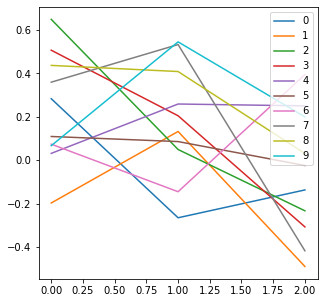

In [37]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

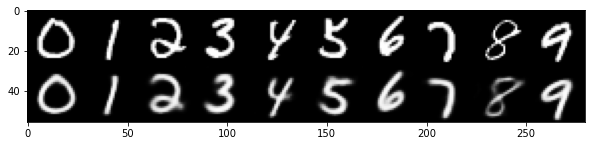

In [38]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [39]:
exn = 5

In [40]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

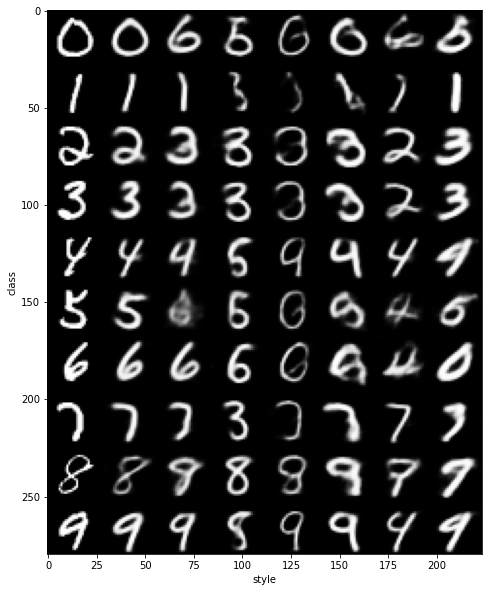

In [41]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [42]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

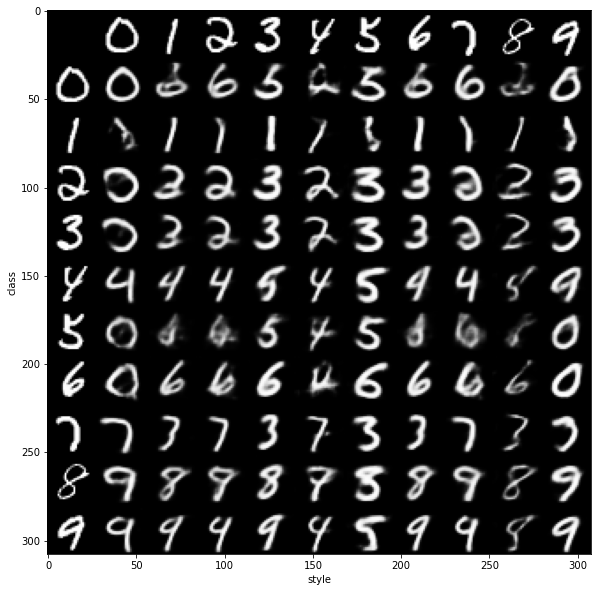

In [43]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()